In [2]:
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb


import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import itertools

## SVC on cc400
Hyperparemeter tuning and feature importance analysis

In [3]:
# load filtered cc400 fc dataset
df = pd.read_csv('/Users/admin/Documents/MscProject/vectorised/fc_cc400_filtered.csv')

In [4]:
df.head()

,#5-#185,#5-#233,#5-#398,#8-#227,#9-#56,#10-#18,#10-#136,#10-#242,#10-#398,#11-#84,...,#314-#398,#319-#350,#321-#351,#322-#367,#327-#389,#327-#399,#339-#365,#347-#389,#361-#372,DX_GROUP
0,-0.465351,-0.038908,-0.303455,0.061997,0.285353,-0.302591,-0.575635,0.093608,-0.311941,0.502320,...,0.105564,0.281348,-0.078890,0.431270,-0.367768,0.088068,0.272958,-0.402212,0.349068,1
1,-0.009303,0.247179,0.019453,-0.089782,0.118145,0.045821,-0.036047,0.138405,0.046357,0.364785,...,0.006089,0.052901,-0.005255,0.166180,0.029733,-0.006374,0.513472,0.115737,0.519810,1
2,-0.131458,0.072728,0.090999,0.324135,0.235671,-0.226198,-0.300777,0.442815,-0.039074,0.477168,...,-0.112499,-0.089670,-0.184399,0.130349,0.320956,0.134839,0.131533,-0.027364,0.234810,1
3,0.155183,0.077839,0.129694,-0.299517,0.191523,-0.196390,-0.279142,0.075303,0.181871,0.709533,...,0.117378,-0.332721,-0.203306,0.292701,0.187288,-0.461183,0.044323,-0.016915,0.198380,1
4,-0.005694,-0.116649,0.046553,-0.101360,-0.211751,0.016708,-0.093205,0.279462,0.240016,0.256403,...,0.069215,-0.025669,-0.043941,0.474094,0.048160,-0.178296,0.238861,-0.083691,-0.080434,1


In [260]:
# isolate X and 7
X = df.iloc[:, :-1]
y = df.iloc[:,-1]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=0,shuffle=True )

In [261]:

classifier = SVC(kernel='rbf').fit(X_train, y_train)
    # make predictions for the left-out test subjects
predictions = classifier.predict(X_val)

score = accuracy_score(y_val, predictions)


In [262]:
score

0.7894736842105263

In [187]:
# get parameters of svc model
classifier.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [263]:
# carry out grid search hyper paremeter tuning
from sklearn.model_selection import GridSearchCV

# defining parameter range, 
param_grid = {'C': [0.1, 0.7,1, 2,2.4],
              'gamma': [23,60, 'scale'],
              'kernel': ['rbf', 'linear']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END .......C=0.1, gamma=23, kernel=rbf;, score=0.513 total time=   0.1s
[CV 2/5] END .......C=0.1, gamma=23, kernel=rbf;, score=0.520 total time=   0.1s
[CV 3/5] END .......C=0.1, gamma=23, kernel=rbf;, score=0.520 total time=   0.1s
[CV 4/5] END .......C=0.1, gamma=23, kernel=rbf;, score=0.520 total time=   0.1s
[CV 5/5] END .......C=0.1, gamma=23, kernel=rbf;, score=0.517 total time=   0.1s
[CV 1/5] END ....C=0.1, gamma=23, kernel=linear;, score=0.796 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=23, kernel=linear;, score=0.789 total time=   0.0s
[CV 3/5] END ....C=0.1, gamma=23, kernel=linear;, score=0.796 total time=   0.0s
[CV 4/5] END ....C=0.1, gamma=23, kernel=linear;, score=0.803 total time=   0.0s
[CV 5/5] END ....C=0.1, gamma=23, kernel=linear;, score=0.748 total time=   0.0s
[CV 1/5] END .......C=0.1, gamma=60, kernel=rbf;, score=0.513 total time=   0.1s
[CV 2/5] END .......C=0.1, gamma=60, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 0.7, 1, 2, 2.4], 'gamma': [23, 60, 'scale'],
                         'kernel': ['rbf', 'linear']},
             verbose=3)

In [264]:
# highest performaing parameters
grid.best_params_

{'C': 2, 'gamma': 'scale', 'kernel': 'rbf'}

In [265]:
grid.best_estimator_.fit(X_train, y_train)

SVC(C=2)

In [266]:
y_val

871    0
568    1
249    1
331    1
492    1
      ..
379    0
484    0
679    0
332    1
879    1
Name: DX_GROUP, Length: 190, dtype: int64

In [267]:
y_pred = grid.best_estimator_.predict(X_val)
accuracy_score(y_val, y_pred)
# the accuracy is lower than default, therefore default shall be kept

0.7789473684210526

## Feature Importance

- infer the importance of features (correlations between regions) via permuation importance

In [268]:
X = df.iloc[:, :-1]
y = df.iloc[:,-1]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=0,shuffle=True )

In [269]:

svc = SVC(kernel='rbf').fit(X_train, y_train)
    # make predictions for the left-out test subjects
predictions = svc.predict(X_val)
    # store the accuracy for this cross-validation fold
score = accuracy_score(y_val, predictions)


In [270]:
score

0.7894736842105263

In [271]:
feature_names = df.columns[:-1] #feature names

In [272]:
#fit permutation importance model to test set, repeat iteration 100 times
perm_importance = permutation_importance(svc, X_val, y_val, n_repeats=100)

feature_names = df.columns[:-1] #feature names

#turn to np array for easy sorting
features = np.array(feature_names)

# get indexes for sorting by mean of importances
sorted_idx = perm_importance.importances_mean.argsort()


In [273]:
#concatenate sorted feature names, with importance means and importance calculated for each repeat
# all sorting is in ascending order of mean importance
perm_imps = np.c_[feature_names[sorted_idx[::-1]],perm_importance.importances_mean[sorted_idx[::-1]],
                  perm_importance.importances[sorted_idx[::-1]]]

In [274]:
# turn to pandas dataframe for ease of use
perm_imp_df = pd.DataFrame(perm_imps)


In [275]:
# assign column names to dataframe
perm_imp_df.columns = ['features', 'mean_importance'] + list(range(1,101))

In [276]:
perm_imp_df

,features,mean_importance,1,2,3,4,5,6,7,8,...,91,92,93,94,95,96,97,98,99,100
0,#10-#398,0.014737,0.015789,0.010526,0.031579,0.015789,0.021053,0.010526,0.010526,0.010526,...,0.010526,0.015789,0.026316,0.021053,0.010526,0.015789,0.015789,0.010526,0.010526,0.010526
1,#143-#375,0.013421,0.010526,0.010526,0.015789,0.026316,0.0,-0.005263,0.026316,0.015789,...,0.010526,0.015789,0.021053,0.015789,0.015789,0.010526,0.010526,0.015789,0.021053,0.005263
2,#129-#364,0.013,0.026316,0.010526,0.026316,0.005263,0.026316,0.015789,0.010526,0.021053,...,0.010526,0.010526,0.015789,0.005263,0.015789,0.031579,0.005263,-0.005263,0.015789,0.010526
3,#228-#264,0.011737,0.015789,0.005263,0.0,0.010526,0.021053,0.015789,0.015789,0.005263,...,0.015789,0.015789,0.015789,0.015789,0.010526,0.010526,0.005263,0.010526,0.010526,0.015789
4,#50-#143,0.011632,0.0,0.0,0.021053,0.005263,0.015789,0.015789,0.010526,0.010526,...,0.015789,0.021053,0.015789,0.0,0.010526,0.010526,0.015789,0.005263,0.005263,0.005263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,#149-#356,-0.003263,0.005263,0.005263,0.010526,0.0,0.005263,0.0,-0.005263,-0.005263,...,0.005263,0.0,0.0,-0.005263,-0.010526,-0.010526,-0.010526,0.0,0.0,-0.010526
256,#155-#237,-0.003368,-0.005263,-0.005263,-0.005263,-0.005263,-0.005263,-0.005263,-0.005263,-0.005263,...,0.0,0.0,-0.010526,-0.005263,-0.005263,-0.005263,0.005263,0.0,-0.005263,0.0
257,#245-#294,-0.003684,-0.005263,0.010526,-0.010526,-0.005263,-0.005263,0.010526,-0.005263,-0.010526,...,-0.010526,0.005263,-0.005263,0.010526,-0.005263,0.0,-0.010526,-0.005263,-0.010526,-0.005263
258,#231-#361,-0.004526,-0.010526,-0.005263,0.0,-0.005263,-0.005263,0.0,0.0,-0.005263,...,0.0,-0.005263,-0.005263,-0.010526,-0.005263,-0.005263,0.0,0.0,-0.005263,0.005263


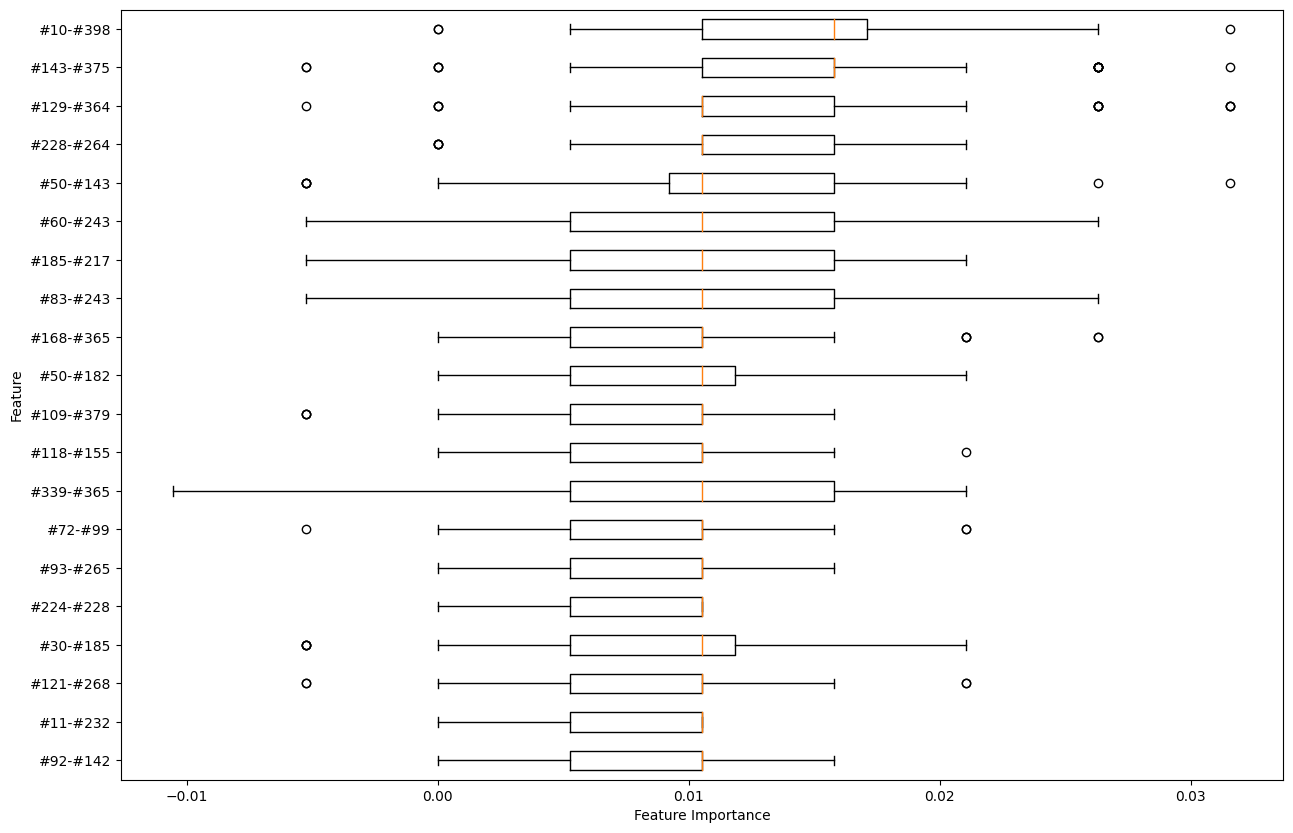

In [278]:
# make boxplot figure of top 20 important features sorted by mean importance
plt.figure(figsize=(15, 10))
plt.boxplot(
    perm_importance.importances[sorted_idx[-20:]].T,
    vert=False,
    labels=feature_names[sorted_idx[-20:]])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()


In [279]:
#save dataframe
perm_imp_df.to_csv('cc400_importance.csv',index=False)

In [283]:
# filter out top 50 most important features from vectorised dataset
highest = df.loc[:,feature_names[sorted_idx][::-1][:50]]

In [284]:
# add target labels to filtered dataset
highest['DX_GROUP']= df['DX_GROUP']

In [285]:
highest

,#10-#398,#143-#375,#129-#364,#228-#264,#50-#143,#60-#243,#185-#217,#83-#243,#168-#365,#50-#182,...,#11-#264,#21-#363,#35-#54,#95-#398,#43-#58,#128-#309,#34-#189,#34-#125,#142-#177,DX_GROUP
0,-0.311941,-0.144689,-0.161888,0.220749,-0.143113,-0.159103,0.228310,-0.194535,0.176123,-0.004307,...,0.535525,-0.226414,0.855091,-0.371493,0.100342,-0.146199,0.049238,-0.030630,-0.193809,1
1,0.046357,0.295373,-0.341964,0.216754,0.155653,0.238897,-0.255685,0.001114,0.299926,0.108865,...,0.491620,-0.040662,0.300424,-0.325109,-0.191302,-0.129303,0.337294,0.086527,-0.223890,1
2,-0.039074,0.001953,0.064289,0.086027,0.067516,-0.359620,-0.184678,-0.118725,0.078467,0.084513,...,0.166410,0.041649,0.215223,0.164969,0.179974,-0.245120,0.113790,0.174130,-0.157862,1
3,0.181871,0.204784,0.346578,0.702050,0.117994,0.028702,-0.181683,-0.021529,0.154351,0.113334,...,0.618172,0.089319,-0.223901,0.314277,0.104723,0.027784,0.093469,-0.089944,0.328213,1
4,0.240016,0.238298,-0.365235,0.127015,0.068589,0.293943,0.020457,-0.183083,-0.203974,0.458913,...,0.466578,-0.083927,0.010151,0.194029,0.167854,-0.018812,-0.064257,-0.029520,0.251763,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,0.376639,0.157417,0.075678,0.506276,0.089802,-0.133793,0.274970,0.083935,0.256384,-0.070188,...,0.084946,0.152940,0.136506,0.273961,-0.243900,-0.133256,0.356074,-0.027037,0.525305,1
945,0.031693,-0.536723,0.002502,0.359627,-0.341926,-0.010272,-0.248394,0.000041,-0.042745,-0.085613,...,0.237421,-0.081136,0.324733,-0.136973,-0.052937,0.096302,0.364027,-0.182622,0.158037,1
946,0.345141,0.011911,-0.450921,0.110386,-0.054446,0.179988,0.134980,-0.246977,0.218163,0.191266,...,0.467352,0.360621,0.285486,-0.035615,0.069473,0.183272,0.195577,0.018968,0.196698,1
947,0.087033,-0.058546,-0.197465,0.014480,0.066734,0.064027,0.151245,-0.154532,0.049200,0.001483,...,0.603215,-0.049399,-0.102998,0.018414,-0.258244,0.036105,0.112084,0.288188,0.225834,1


In [286]:
#save dataframe
highest.to_csv('cc400_highest_features.csv', index=False)

In [287]:
#get top 20 highest features
high_20 = df.loc[:,feature_names[sorted_idx][::-1][:50]]
high_20['DX_GROUP']= df['DX_GROUP']

In [288]:
# get names of 20 most important features
high20_feats = feature_names[sorted_idx][::-1][:50].to_list()

In [289]:
# split features into two, to get regions of interest
split_feats = [high20_feats[i].split("-")for i in range(len(high20_feats))]

In [290]:
#groupby the diagnosis group and find mean of each feature
grouped = high_20.groupby(by= 'DX_GROUP').mean()
grouped

,#10-#398,#143-#375,#129-#364,#228-#264,#50-#143,#60-#243,#185-#217,#83-#243,#168-#365,#50-#182,...,#175-#379,#11-#264,#21-#363,#35-#54,#95-#398,#43-#58,#128-#309,#34-#189,#34-#125,#142-#177
DX_GROUP,,,,,,,,,,,,,,,,,,,,,
0,0.039006,-0.006734,-0.016623,0.304754,0.003881,0.191918,-0.050191,-0.096290,0.123913,0.050855,...,0.082471,0.401383,0.005064,0.189626,-0.03679,-0.061798,-0.025244,0.280045,-0.052885,0.190731
1,0.106936,0.051171,-0.072642,0.204625,0.060874,0.124885,0.021663,-0.030682,0.061058,0.112096,...,0.015231,0.308250,0.075174,0.109439,0.03406,0.000502,0.041174,0.197056,0.003672,0.104442


In [291]:
# split classes into separate arrays
highest_0,highest_1 = grouped.iloc[0,:],grouped.iloc[1,:]
# get values of each array
high_0_val, high_1_val = highest_0.values.tolist(), highest_1.values.tolist()

In [292]:
# add correlation value to list of two nodes for each group
control_highest = [nodes + [high_0_val[i]] for i,nodes in enumerate(split_feats)]
asd_highest = [nodes + [high_1_val[i]] for i,nodes in enumerate(split_feats)]

In [293]:
control_CC400 = pd.DataFrame(control_highest, columns= ['roi_1','roi_2','correlation'])
asd_CC400 = pd.DataFrame(asd_highest, columns= ['roi_1','roi_2','correlation'])


In [294]:
control_CC400

,roi_1,roi_2,correlation
0,#10,#398,0.039006
1,#143,#375,-0.006734
2,#129,#364,-0.016623
3,#228,#264,0.304754
4,#50,#143,0.003881
5,#60,#243,0.191918
6,#185,#217,-0.050191
7,#83,#243,-0.096290
8,#168,#365,0.123913
9,#50,#182,0.050855


In [295]:
control_CC400.to_csv('cc400_control_adj.csv', index=False)
asd_CC400.to_csv('cc400_asd_adj.csv', index=False)